<a href="https://colab.research.google.com/github/shahin1009/Lorenz-AutoEncoder-DeepLearning/blob/main/Lorenzlearner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


np.random.seed(123)
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

In [2]:
beta = 8/3
sigma = 10
rho = 28
def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

## Simulate the Lorenz System

In [3]:
n_train = 1000
dt = 0.01
T = 20
t = np.arange(0,T+dt,dt)
l = len(t)
#initial points that will be transiented to the attractor
x0 = -15 + 30 * np.random.random((n_train, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])

In [4]:
# checking the shapes
print(t.shape)
print(x_t.shape)

(2002,)
(1000, 2002, 3)


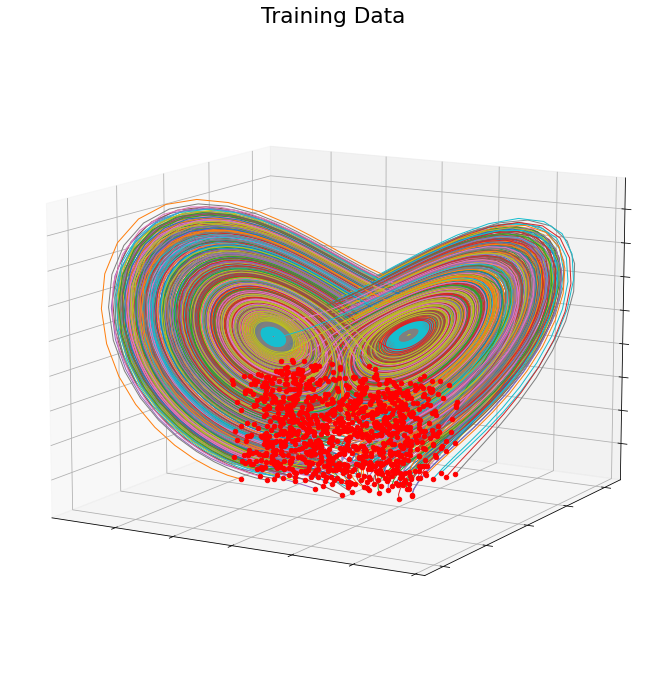

In [5]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
# input initialization
nn_input = np.zeros((n_train*(l-1),3))
nn_output = np.zeros_like(nn_input)

# Creating and plotting the coarse input and output data from calculated PDE
for j in range(n_train):
    nn_input[j*(l-1):(j+1)*(l-1),:] = x_t[j,:-1,:]
    nn_output[j*(l-1):(j+1)*(l-1),:] = x_t[j,1:,:]
    x, y, z = x_t[j,:,:].T
    ax.plot(x, y, z,linewidth=1)
    ax.scatter(x0[j,0],x0[j,1],x0[j,2],color='r')

# plotting the data

ax.view_init(12, 120)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.set_title('Training Data')
plt.show()

## Neural Net


In [6]:
nn_output.shape

(2001000, 3)

In [8]:

class Autoencoder(Model):
  def __init__(self):
    super(Autoencoder, self).__init__() 
    
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='relu'),
    ])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(256, activation='relu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(3, activation='linear'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(nn_input, nn_output,
                epochs=20,batch_size = 256)


Epoch 1/20
7817/7817 [==============================] - 28s 3ms/step - loss: 0.1882
Epoch 2/20
7817/7817 [==============================] - 27s 3ms/step - loss: 0.0116
Epoch 3/20
7817/7817 [==============================] - 28s 4ms/step - loss: 0.0081
Epoch 4/20
7817/7817 [==============================] - 26s 3ms/step - loss: 0.0063
Epoch 5/20
7817/7817 [==============================] - 26s 3ms/step - loss: 0.0051
Epoch 6/20
7817/7817 [==============================] - 26s 3ms/step - loss: 0.0044
Epoch 7/20
7817/7817 [==============================] - 27s 3ms/step - loss: 0.0039
Epoch 8/20
7817/7817 [==============================] - 26s 3ms/step - loss: 0.0036
Epoch 9/20
7817/7817 [==============================] - 27s 3ms/step - loss: 0.0032
Epoch 10/20
7817/7817 [==============================] - 26s 3ms/step - loss: 0.0031
Epoch 11/20
7817/7817 [==============================] - 26s 3ms/step - loss: 0.0029
Epoch 12/20
7817/7817 [==============================] - 27s 3ms/step - lo

63/63 [==============================] - 0s 2ms/step


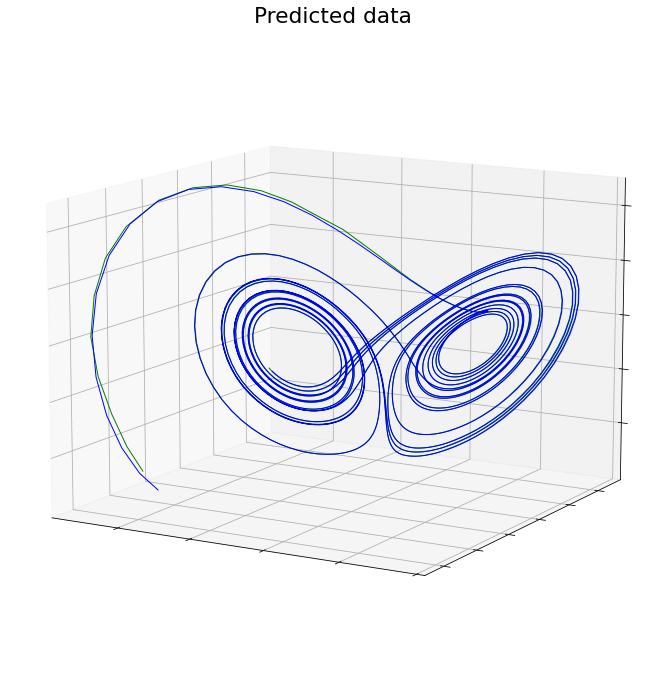

In [9]:
fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
x0new = -5 + 30 * np.random.random(3)

x_t = integrate.odeint(lorenz_deriv, x0new, t)
  
y_pred = autoencoder.predict(x_t)

x, y, z = y_pred.T
ax.plot(x, y, z,linewidth=1,color='green')
x0 , y0 , z0 = x_t.T
ax.plot(x0 , y0 , z0,linewidth=1,color='blue')
ax.view_init(12, 120)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.set_title('Predicted data')
plt.show()

In [10]:
x0new = -2 + 30 * np.random.random(3)
x_t = integrate.odeint(lorenz_deriv, x0new, t)
x_t0 = x_t
ou = np.zeros((100,3))
for i in np.arange(100):
  y_pred = autoencoder.predict(x_t);
  x, y, z = y_pred.T
  ou[i , :] = np.array([x[-1] , y[-1] , z[-1]])
  x_t=y_pred

63/63 [==============================] - 0s 2ms/step


In [11]:
x0new = x_t0[-1 , :]
dt = 0.01
T = 1
t = np.arange(0,T+dt,dt)
ou_real = integrate.odeint(lorenz_deriv, x0new, t)

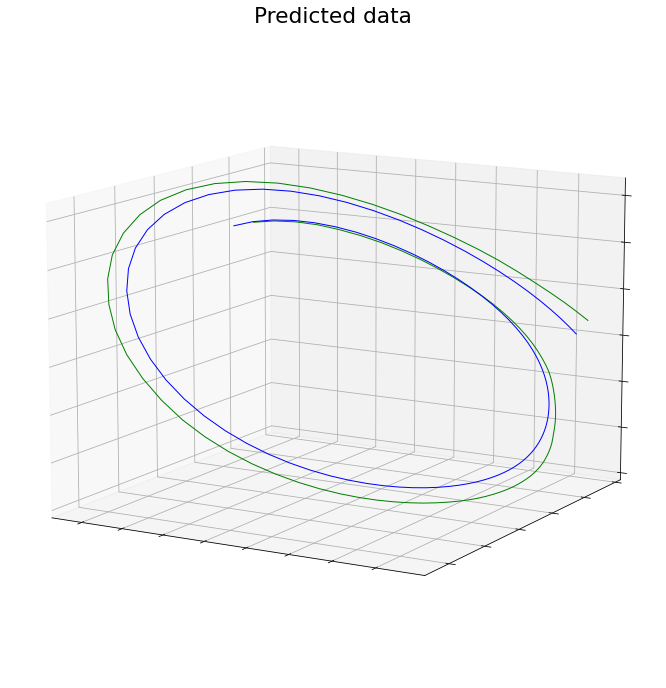

In [12]:
ou.shape

fig,ax = plt.subplots(1,1,subplot_kw={'projection': '3d'})
x, y, z = ou.T
ax.plot(x, y, z,linewidth=1,color='green')
x_, y_, z_ = ou_real.T
ax.plot(x_, y_, z_,linewidth=1,color='blue')
ax.view_init(12, 120)
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])
ax.set_title('Predicted data')
plt.show()